# 交互式参数扫描与敏感性分析（MPh + Tritium Cycle）

本笔记本提供一个交互式脚本：
1. 展示模型所有参数
2. 用户输入待分析参数（校验是否存在）
3. 用户输入扫描范围（仅支持数值列表）
4. 用户选择分析指标（多工况 SDS 时间曲线 / 结束库存 / 启动氚投料 / 自持时间）
5. 执行求解并生成图像

In [1]:
import mph
import os
import numpy as np
import matplotlib.pyplot as plt

# 启动 Comsol 客户端
try:
    client = mph.start()
    print(f"MPh {mph.__version__} connected to Comsol {client.version}")
except Exception as e:
    raise RuntimeError(f"Connection failed: {e}")

# 自动查找并加载模型
model_name = 'tritum_cycle_Model.mph'
search_paths = [
    model_name,
    os.path.join('..', 'experiment_00', model_name),
    r'D:\Administrator\Documents\Github\tricys_mph\experiment_00\tritum_cycle_Model.mph',
]

model = None
for p in search_paths:
    if os.path.exists(p):
        print(f"Loading model from: {p} ...")
        model = client.load(p)
        break

if not model:
    raise FileNotFoundError(f"无法找到 {model_name}，请检查路径。")

print("Model loaded successfully.")

MPh 1.2.4 connected to Comsol 6.2
Loading model from: tritum_cycle_Model.mph ...
Model loaded successfully.


In [2]:
# 1. 展示模型所有参数
params_raw = model.parameters(evaluate=False)
print(f"Total parameters: {len(params_raw)}")
print('--- Parameter List ---')
for k in sorted(params_raw.keys()):
    print(f"{k}: {params_raw[k]}")

Total parameters: 60
--- Parameter List ---
AF: 0.5
I10_sat: 200[g]
I11_sat: 300[g]
I12_ini: 3.5[kg]
I13_sat: 20[g]
I14_sat: 1000[g]
I2_sat: 640[g]
I9_sat: 200[g]
P_fusion: 1500[MW]
T1: 0.5[h]
T10: 12[h]
T11: 6[h]
T13: 6[h]
T14: 48[h]
T15: 5[s]
T2: 0.17[h]
T3: 2[h]
T4: 0.28[h]
T5: 0.28[h]
T6: 24[h]
T7: 24[h]
T8: 24[h]
T9: 48[h]
TBR: 1.1
T_cycle: 3[h]
beta: 0.06
epsilon1: 1e-4
epsilon10: 1e-4
epsilon11: 1e-4
epsilon12: 1e-4
epsilon13: 1e-4
epsilon14: 1e-4
epsilon2: 1e-4
epsilon3: 1e-4
epsilon4: 1e-4
epsilon5: 1e-4
epsilon6: 1e-4
epsilon7: 1e-4
epsilon8: 1e-4
epsilon9: 1e-4
f10_13: 1
f11_12: 0.99999999
f11_14: 1e-8
f13_12: 1
f14_13: 1
f15_2: 0.9998
f15_4: 1e-4
f15_5: 1e-4
f3_11: 0.15
f3_12: 0.85
f6_10: 0.95
f6_7: 0.05
f7_14: 1e-4
f7_9: 0.9999
f8_14: 1e-4
f8_9: 0.9999
f9_13: 1
f_e: 0.5
factor1: 1.7805e-6[g/s/MW]
lanmda: 1.78e-9[1/s]


In [3]:
# 2. 交互输入：待分析参数（校验是否存在）
param_name = input('请输入待分析参数名（如 P_fusion / TBR / beta / AF）：').strip()
if param_name not in params_raw:
    raise ValueError(f"参数 {param_name} 不存在，请检查拼写。")
print(f"参数 {param_name} 存在，当前值：{params_raw[param_name]}")

参数 TBR 存在，当前值：1.1


In [4]:
# 3. 交互输入：扫描范围（仅支持数值列表）
raw_list = input('请输入扫描数值列表（用逗号分隔，如 500,1000,1500,2000）：').strip()
scan_values = [float(x) for x in raw_list.split(',') if x.strip() != '']
if not scan_values:
    raise ValueError('扫描列表为空。')
print('扫描列表：', scan_values)

扫描列表： [1.1, 1.05]


In [5]:
# 4. 选择分析指标
print('请选择分析指标（可多选，逗号分隔）：')
print('1) 多工况 SDS 库存时间曲线')
print('2) 结束库存 (I12_end)')
print('3) 启动氚投料 (startup_feed)')
print('4) 自持时间 (reserve_time)')

choice_raw = input('请输入编号列表（如 1,2,4）：').strip()
choices = {int(x) for x in choice_raw.split(',') if x.strip().isdigit()}
if not choices:
    raise ValueError('未选择任何指标。')
print('已选择：', choices)

请选择分析指标（可多选，逗号分隔）：
1) 多工况 SDS 库存时间曲线
2) 结束库存 (I12_end)
3) 启动氚投料 (startup_feed)
4) 自持时间 (reserve_time)
已选择： {1, 2, 3, 4}


Running solve for TBR = 1.1 ...
Running solve for TBR = 1.05 ...
Parameter restored to original value.


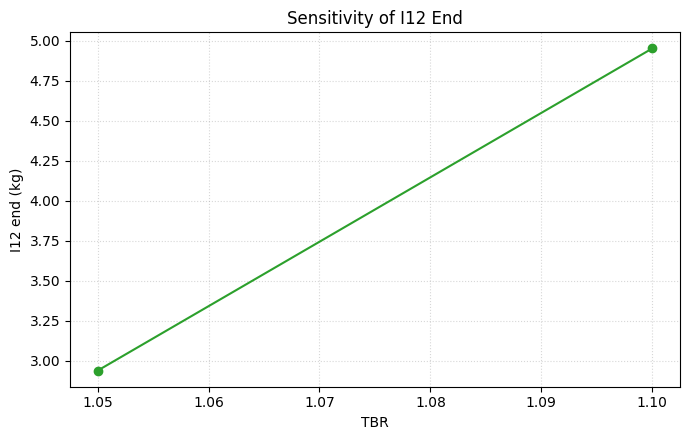

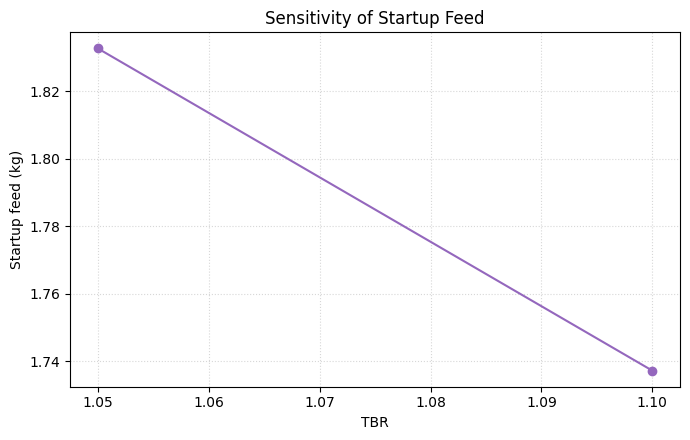

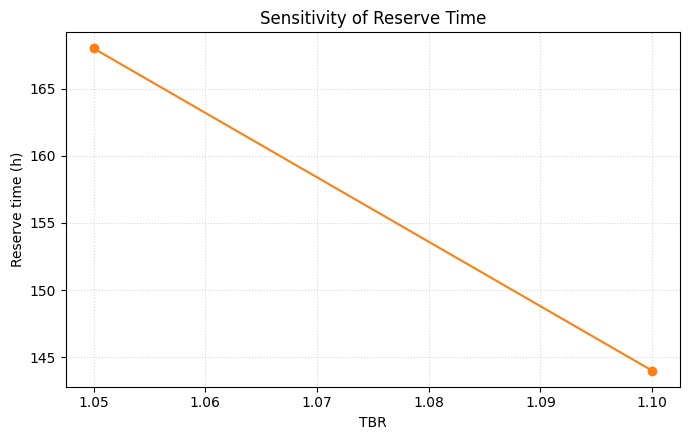

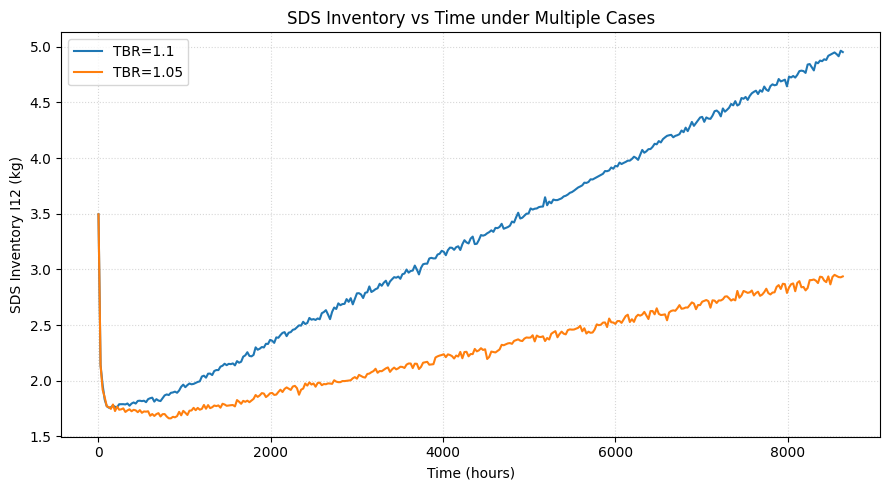

In [6]:
# 5. 开始运行并生成图片
original_value = model.parameter(param_name)
results = []
time_series = {}
time_hours = None

for val in scan_values:
    # 设置参数（默认单位由模型定义；如需单位请输入带单位的字符串）
    model.parameter(param_name, val)
    print(f'Running solve for {param_name} = {val} ...')
    model.solve()

    # I12 时间序列（kg）
    i12 = model.evaluate('I12', unit='kg')
    i12_series = np.array(i12).astype(float)
    i12_last = float(i12_series[-1]) if i12_series.size else float(i12)

    if time_hours is None:
        time_hours = np.array(model.evaluate('t', unit='h')).astype(float)
    time_series[val] = i12_series

    # 启动氚投料量 & 自持时间
    i12_init = float(i12_series[0]) if i12_series.size else float(i12)
    i12_min = float(i12_series.min()) if i12_series.size else float(i12)
    startup_feed = i12_init - i12_min

    reserve_time = None
    if i12_series.size > 2:
        diffs = np.diff(i12_series)
        has_negative = False
        for idx, d in enumerate(diffs):
            if d < 0:
                has_negative = True
            if has_negative and d > 0:
                reserve_time = float(time_hours[idx + 1])
                break

    results.append({
        'param_value': val,
        'I12_end_kg': i12_last,
        'startup_feed_kg': startup_feed,
        'reserve_time_h': reserve_time,
    })

# 恢复原始参数
model.parameter(param_name, original_value)
print('Parameter restored to original value.')

# 绘图（根据选择的指标）
x = [r['param_value'] for r in results]

if 2 in choices:
    y = [r['I12_end_kg'] for r in results]
    plt.figure(figsize=(7, 4.5))
    plt.plot(x, y, 'o-', color='tab:green')
    plt.xlabel(param_name)
    plt.ylabel('I12 end (kg)')
    plt.title('Sensitivity of I12 End')
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

if 3 in choices:
    y = [r['startup_feed_kg'] for r in results]
    plt.figure(figsize=(7, 4.5))
    plt.plot(x, y, 'o-', color='tab:purple')
    plt.xlabel(param_name)
    plt.ylabel('Startup feed (kg)')
    plt.title('Sensitivity of Startup Feed')
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

if 4 in choices:
    y = [np.nan if r['reserve_time_h'] is None else r['reserve_time_h'] for r in results]
    plt.figure(figsize=(7, 4.5))
    plt.plot(x, y, 'o-', color='tab:orange')
    plt.xlabel(param_name)
    plt.ylabel('Reserve time (h)')
    plt.title('Sensitivity of Reserve Time')
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

if 1 in choices and time_hours is not None:
    plt.figure(figsize=(9, 5))
    for val in scan_values:
        series = time_series.get(val)
        if series is not None:
            plt.plot(time_hours, series, label=f'{param_name}={val}')
    plt.xlabel('Time (hours)')
    plt.ylabel('SDS Inventory I12 (kg)')
    plt.title('SDS Inventory vs Time under Multiple Cases')
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()